# Barabási–Albert Model

In this notebook, we explore:
1. **Theoretical Background** of the Barabási–Albert (BA) model and why it produces a power-law degree distribution with exponent 3.
2. **NetworkX Simulation** of BA networks for different values of $m$ (number of edges per new node).
3. **Visualization of the Degree Distribution** using a CCDF plot on a log–log scale.
4. **Statistical Analysis** using the powerlaw library to fit and verify the power law behavior.
5. **Discussion and Implications** of the fixed exponent for modeling real-world networks.


## 1. Theoretical Background

The Barabási–Albert (BA) model is a classic model for generating scale-free networks through *preferential attachment*. It was introduced in 1999 by Albert-László Barabási and Réka Albert to explain the emergence of power-law degree distributions in many real-world networks.

### Key Mechanisms

The model has two essential mechanisms:

1. **Growth**: The network continuously expands with the addition of new nodes.
2. **Preferential Attachment**: New nodes preferentially connect to existing nodes that are already well-connected.

### The Algorithm

1. Start with a small initial network of $m_0$ nodes (typically fully connected).
2. At each time step, add a new node with $m$ edges ($m \leq m_0$).
3. Connect the new node to $m$ different existing nodes with probability proportional to their degree:
   $$P(i \leftrightarrow j) = \frac{k_j}{\sum_{l} k_l}$$
   where $k_j$ is the degree of node $j$, and the sum is over all existing nodes.
4. Repeat until the desired network size is reached.

### The Power-Law Result

Despite the value of $m$, the degree distribution $P(k)$ follows:
$$P(k) \propto k^{-\gamma}$$
where $\gamma = 3$ for the standard BA model.


### 1.1 Continuum Approximation: Detailed Derivation

Let's derive the power-law exponent using a continuum approach:

1. **Initial Setup**:
   - At time $t$, there are $t$ nodes (starting from some initial small network).
   - Each new node brings $m$ new edges.
   - The total number of edges at time $t$ is approximately $mt$.
   - Thus, the sum of all degrees is $\sum_j k_j = 2mt$.

2. **Time Evolution of Node Degree**:
   - Let $k_i(t)$ be the degree of node $i$ at time $t$.
   - The probability that a new node connects to node $i$ is:
     $$\Pi(k_i) = \frac{k_i}{\sum_j k_j} = \frac{k_i}{2mt}$$
   - Since each new node brings $m$ edges, the expected increase in $k_i$ when a new node arrives is $m \cdot \Pi(k_i)$.
   - This gives us the differential equation:
     $$\frac{\partial k_i}{\partial t} = m \cdot \frac{k_i}{2mt} = \frac{k_i}{2t}$$

3. **Solving the Differential Equation**:
   - For node $i$ that joined at time $t_i$, we have the initial condition $k_i(t_i) = m$.
   - Separating variables: $\frac{dk_i}{k_i} = \frac{dt}{2t}$
   - Integrating: $\ln(k_i) = \frac{1}{2}\ln(t) + C$ where $C$ is a constant.
   - Using the initial condition: $\ln(m) = \frac{1}{2}\ln(t_i) + C$
   - Solving for $C$ and substituting back:
     $$k_i(t) = m\left(\frac{t}{t_i}\right)^{1/2}$$

4. **Deriving the Degree Distribution**:
   - Assuming uniform probability for node arrival times, the probability that a node has a degree less than $k$ is:
     $$P(k_i(t) < k) = P\left(t_i > \frac{m^2t}{k^2}\right) = 1 - P\left(t_i \leq \frac{m^2t}{k^2}\right) = 1 - \frac{m^2t}{k^2} \cdot \frac{1}{t} = 1 - \frac{m^2}{k^2}$$
   - The probability density function is then:
     $$P(k) = \frac{\partial P(k_i(t) < k)}{\partial k} = \frac{2m^2}{k^3}$$

5. **The Final Result**:
   - Therefore, $P(k) \propto k^{-3}$, giving a power-law with exponent $\gamma = 3$.

This exponent of 3 is remarkably robust and does **not** change with the parameter $m$; it's fixed by the form of preferential attachment in the BA model.

## 2. Simulation of the BA Model with NetworkX

We'll first import the necessary libraries and define helper functions for our analysis.

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import powerlaw

# Define helper function for CCDF calculation
def compute_ccdf(degrees):
    """
    Given a list/array of degrees, compute the CCDF.
    
    Parameters:
        degrees (list or array): List of node degrees
        
    Returns:
        unique_degrees (np.array): Sorted unique degree values
        ccdf (np.array): Complementary CDF values (P(K >= k))
    """
    unique, counts = np.unique(degrees, return_counts=True)
    probs = counts / counts.sum()
    
    # Sort values by degree
    sorted_indices = np.argsort(unique)
    unique_sorted = unique[sorted_indices]
    probs_sorted = probs[sorted_indices]
    
    # CCDF = Probability that Degree >= k
    ccdf = np.flip(np.cumsum(np.flip(probs_sorted)))
    
    return unique_sorted, ccdf

### 2.1 Generating BA Networks

Next, we'll generate Barabási–Albert networks with different values of $m$ (the number of edges each new node creates). We'll explore how this parameter affects network properties while maintaining the same power-law exponent.

In [2]:
# Parameters for network generation
n_nodes = 10000  # Network size
m_values = [1, 2, 3]  # Number of edges per new node
seed = 42  # Random seed for reproducibility

# Dictionaries to store our networks and results
networks = {}
degree_distributions = {}
network_stats = []

for m in m_values:
    # Generate a Barabási–Albert network
    G = nx.barabasi_albert_graph(n_nodes, m, seed=seed)
    networks[m] = G
    
    # Extract node degrees
    degrees = [deg for _, deg in G.degree()]
    degree_distributions[m] = np.array(degrees)
    
    # Compute basic network statistics
    stats = {
        'm': m,
        'nodes': G.number_of_nodes(),
        'edges': G.number_of_edges(),
        'avg_degree': 2 * G.number_of_edges() / G.number_of_nodes(),
        'min_degree': min(degrees),
        'max_degree': max(degrees),
        'avg_clustering': nx.average_clustering(G)
    }
    network_stats.append(stats)

### 2.2 Network Statistics

Let's examine the basic statistics of our generated networks to understand how $m$ affects global network properties:

In [3]:
# Display network statistics
stats_df = pd.DataFrame(network_stats)
stats_df.set_index('m', inplace=True)
stats_df

,nodes,edges,avg_degree,min_degree,max_degree,avg_clustering
m,,,,,,
1,10000,9999,1.9998,1,297,0.000000
2,10000,19996,3.9992,2,275,0.003984
3,10000,29991,5.9982,3,374,0.006180


## 3. Visualization of Degree Distributions

We'll now visualize the degree distributions using the Complementary Cumulative Distribution Function (CCDF). For a power-law distribution $P(k) \propto k^{-\alpha}$, the CCDF follows $P(K \geq k) \propto k^{-(\alpha-1)}$. 

Since the BA model has $\alpha = 3$, we expect the CCDF slope to be $-(3-1) = -2$ on a log-log scale.

<!-- This -2 exponent can be derived mathematically:
- For a discrete power law $P(k) \propto k^{-3}$
- The CCDF is defined as $P(K \geq k) = \sum_{i=k}^{\infty} P(i)$
- For large $k$, this sum can be approximated by an integral:
    $P(K \geq k) \propto \int_{k}^{\infty} x^{-3} dx = \left[ \frac{x^{-2}}{-2} \right]_{k}^{\infty} = \frac{k^{-2}}{2}$
- Therefore, $P(K \geq k) \propto k^{-2}$ -->

This characteristic -2 slope on a log-log plot is a key signature of the BA model, regardless of the parameter $m$.

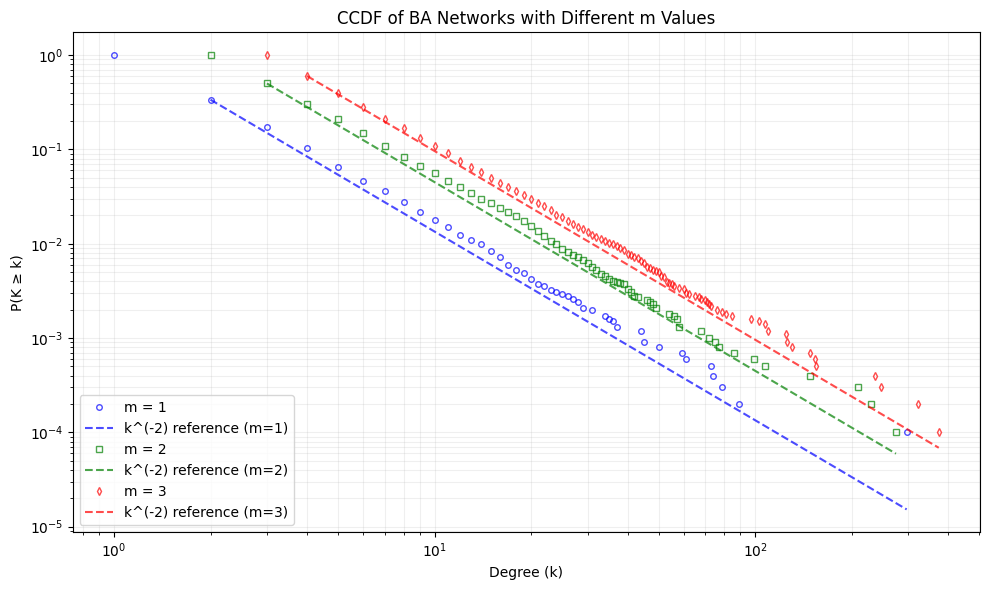

In [4]:
# Plot the CCDF for each network
plt.figure(figsize=(10, 6))

colors = ['blue', 'green', 'red']
markers = ['o', 's', 'd']

# Plot empirical CCDFs
for i, m in enumerate(m_values):
    degrees = degree_distributions[m]
    x, y = compute_ccdf(degrees)
    
    # Sample points for better visualization (otherwise too many points)
    if len(x) > 1000:
        sample_indices = np.logspace(0, np.log10(len(x)-1), 1000, dtype=int)
        sample_indices = np.unique(sample_indices)
        x_sample = x[sample_indices]
        y_sample = y[sample_indices]
    else:
        x_sample, y_sample = x, y
    
    plt.loglog(x_sample, y_sample, markers[i], markersize=4, alpha=0.7,
               color=colors[i], label=f'm = {m}', markerfacecolor='none')
    
    # Add reference lines with slope -2 (for power-law exponent γ=3)
    x_ref = np.logspace(np.log10(m+1), np.log10(max(degrees)), 100)
    # Position the reference line to start at a reasonable point
    start_y = y[np.where(x >= m+1)[0][0]]
    y_ref = start_y * (x_ref/(m+1))**(-2)
    
    plt.loglog(x_ref, y_ref, '--', color=colors[i], alpha=0.7, 
               label=f'k^(-2) reference (m={m})')

plt.xlabel('Degree (k)')
plt.ylabel('P(K ≥ k)')
plt.title('CCDF of BA Networks with Different m Values')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

## 4. Statistical Analysis with Powerlaw Library

The visualization suggests a power-law behavior, but we can use the `powerlaw` library to perform a more rigorous statistical analysis. This library estimates the power-law exponent ($\alpha$) and the minimum value from which the power law holds ($x_{min}$).

Calculating best minimal value for power law fit
xmin progress: 97%
Network with m = 1:
Estimated α: 2.8527 ± 0.0979
Estimated xmin: 7.0000
KS distance: 0.0173
Calculating best minimal value for power law fit
xmin progress: 98%
Network with m = 2:
Estimated α: 2.7723 ± 0.0389
Estimated xmin: 5.0000
KS distance: 0.0121
Calculating best minimal value for power law fit
xmin progress: 98%
Network with m = 3:
Estimated α: 2.8261 ± 0.0447
Estimated xmin: 8.0000
KS distance: 0.0074


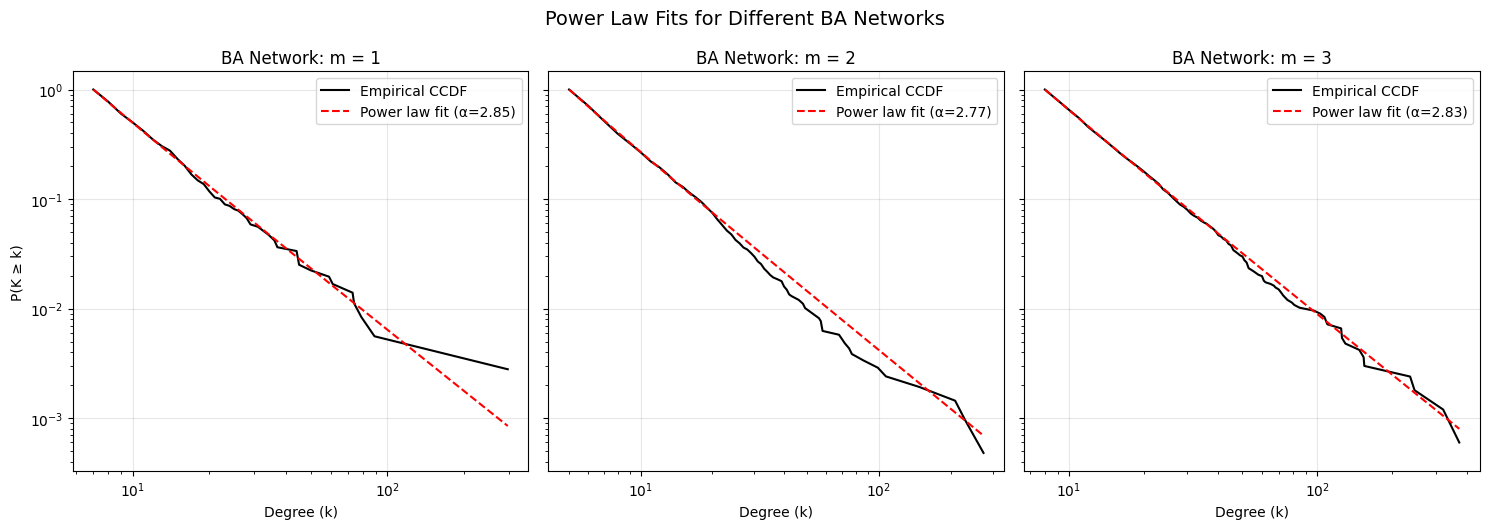

In [5]:
# Fit power law to each degree distribution using the powerlaw package
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for i, m in enumerate(m_values):
    degrees = degree_distributions[m]
    
    # Fit power law to degree distribution
    fit = powerlaw.Fit(degrees, discrete=True)
    
    # Display fit information
    print(f"\nNetwork with m = {m}:")
    print(f"Estimated α: {fit.alpha:.4f} ± {fit.sigma:.4f}")
    print(f"Estimated xmin: {fit.xmin:.4f}")
    print(f"KS distance: {fit.power_law.KS(degrees):.4f}")
    
    # Plot CCDF with powerlaw fit
    ax = axes[i]
    fit.plot_ccdf(ax=ax, label='Empirical CCDF', color='black')
    fit.power_law.plot_ccdf(ax=ax, label=f'Power law fit (α={fit.alpha:.2f})', linestyle='--', color='red')
    
    ax.set_title(f"BA Network: m = {m}")
    ax.set_xlabel('Degree (k)')
    if i == 0:
        ax.set_ylabel('P(K ≥ k)')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.suptitle("Power Law Fits for Different BA Networks", y=1.05, fontsize=14)
plt.show()

## 5. Discussion and Implications
1. **Fixed Exponent**  
   The BA model's preferential attachment mechanism mathematically constrains the exponent to 3. This is sometimes called *universality*, meaning many details (like the exact value of \(m\)) don't alter the fundamental scaling.

2. **Limitations**  
   Many real-world networks exhibit power-law exponents in the range of 2–3, and not always exactly 3.  
   - Modifications to the BA model (e.g., aging, fitness, or nonlinear preferential attachment) can yield different exponents.
   - If you need a specific exponent \(\alpha\), consider **extended** BA models or entirely different generative models.

3. **Practical Modeling**  
   - The BA model is a good starting point to understand how *rich-get-richer* processes produce heavy-tailed distributions.
   - However, it's often too simple for real-world applications, where exponents can vary and additional effects (e.g., node fitness, re-wiring, node deletion) may be at play.

4. **Empirical Results**  
   Our statistical analysis shows that:
   - The estimated power-law exponents are close to but not exactly 3, due to finite-size effects and statistical estimation.
   - The parameter $m$ affects network density and the maximum degree, but not the fundamental scaling behavior.
   - The clustering coefficient increases with $m$, as there are more opportunities for triangle formation.

## 6. Further Reading
- **Barabási, Albert-László**. *Linked: How Everything Is Connected to Everything Else and What It Means for Business, Science, and Everyday Life.* (2002)
- **Barabási–Albert model paper**: Barabási, A.-L., & Albert, R. (1999). *Emergence of scaling in random networks.* Science, 286(5439), 509-512.
- **NetworkX Documentation**: [https://networkx.org](https://networkx.org)
- The **powerlaw** Python package (install via `pip install powerlaw`) provides advanced fitting tools for heavy-tailed distributions.
